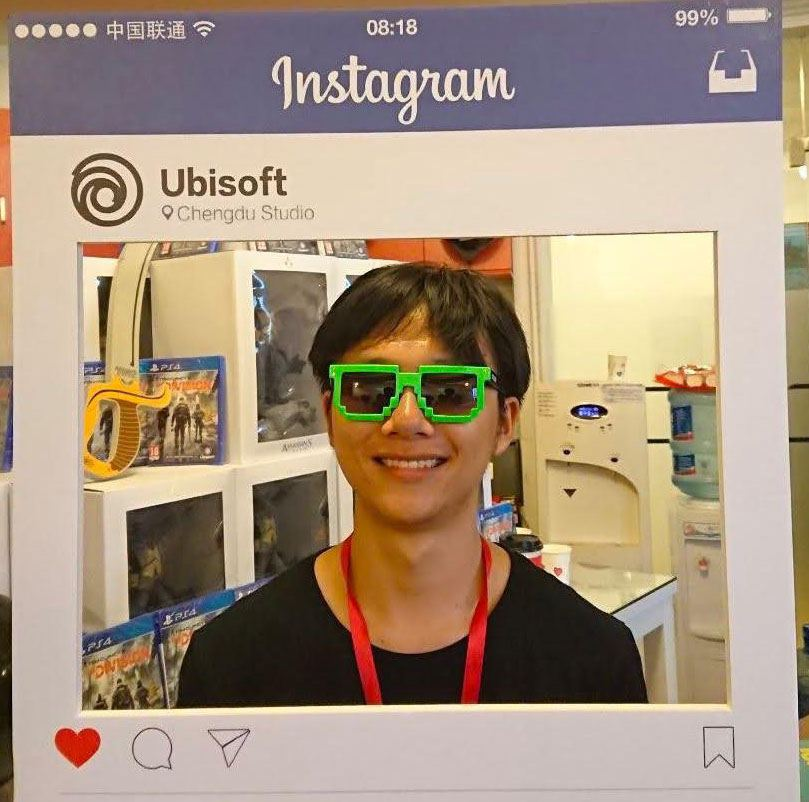

In [ ]:
# %%

import torch
from PIL import Image
import requests

url = "https://huzeyann.github.io/assets/img/prof_pic_old.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# %%

# use DiNOv2 features
from ncut_feature_extractors import image_dinov2_feature as feature_extractor
# or use SAM features
# from ncut_feature_extractors import image_sam_feature as feature_extractor
feat = feature_extractor(image, resolution=(448, 448), layer=9)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [ ]:
# %%

# apply ncut to the features, each patch of pixels (token) is a node
from ncut_pytorch import NCUT

h, w, c = feat.shape
print("Feature shape:", feat.shape)  # "Feature shape: torch.Size([32, 32, 768])

n = h * w  # flatten the pixels into nodes
feat = feat.reshape(n, c)
model = NCUT(num_eig=20)
eigenvectors, eigenvalues = model.fit_transform(feat)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Feature shape: torch.Size([32, 32, 768])
Eigenvalues: tensor([1.0000, 0.0980, 0.0871, 0.0771, 0.0595, 0.0380, 0.0306, 0.0267, 0.0199,
        0.0186, 0.0168, 0.0156, 0.0150, 0.0126, 0.0123, 0.0118, 0.0110, 0.0090,
        0.0088, 0.0084])
Eigenvectors shape: torch.Size([1024, 20])


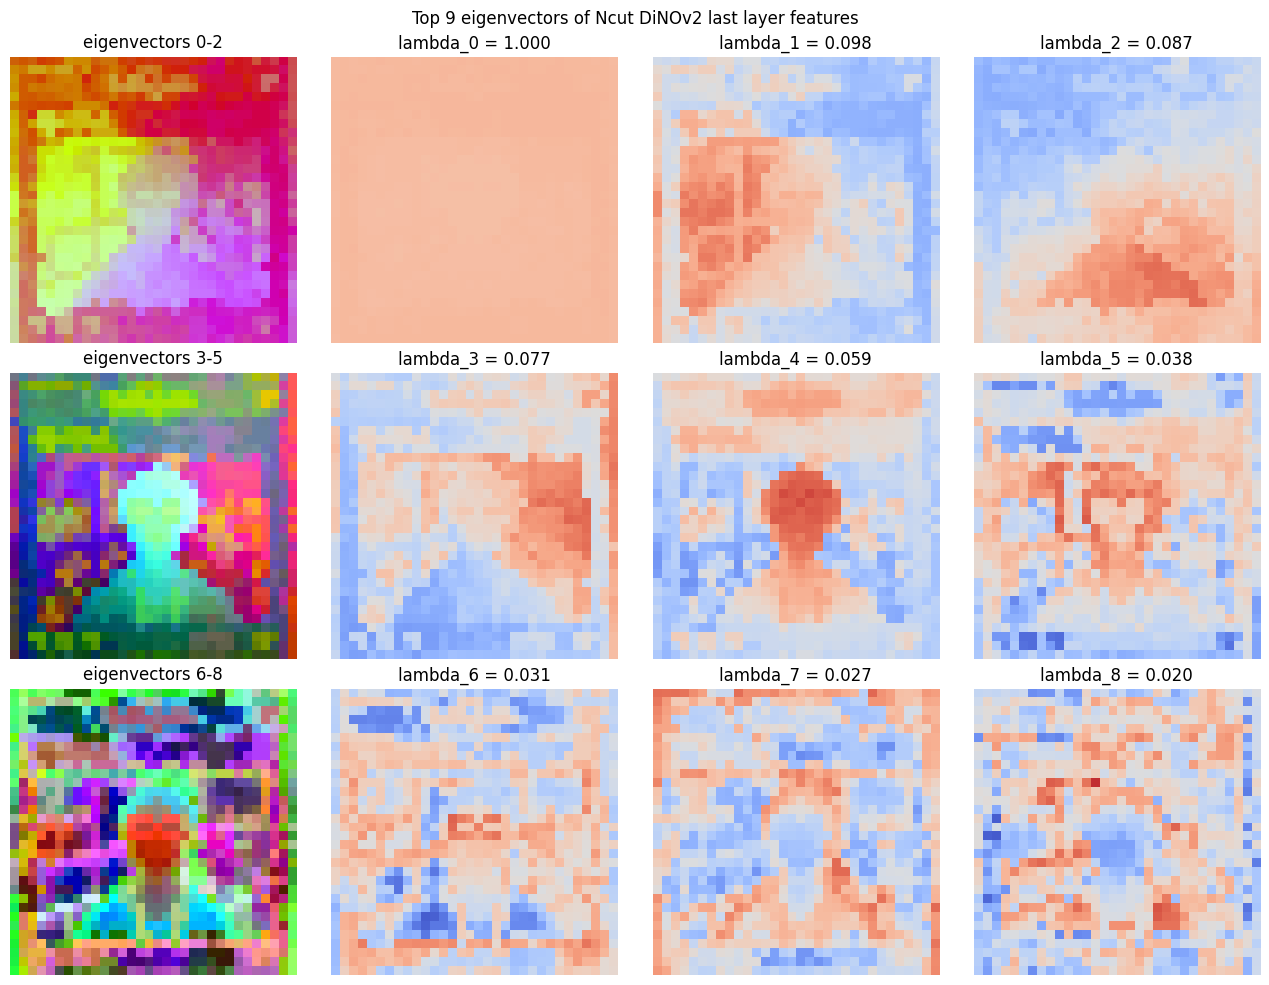

In [ ]:
# %%

# visualize top 9 eigenvectors, 3 eigenvectors per row
import matplotlib.pyplot as plt
from ncut_pytorch import quantile_normalize
fig, axs = plt.subplots(3, 4, figsize=(13, 10))
i_eig = 0
for i_row in range(3):
    for i_col in range(1, 4):
        ax = axs[i_row, i_col]
        ax.imshow(eigenvectors[:, i_eig].reshape(h, w), cmap="coolwarm", vmin=-0.1, vmax=0.1)
        ax.set_title(f"lambda_{i_eig} = {eigenvalues[i_eig]:.3f}")
        ax.axis("off")
        i_eig += 1
for i_row in range(3):
    ax = axs[i_row, 0]
    start, end = i_row * 3, (i_row + 1) * 3
    rgb = quantile_normalize(eigenvectors[:, start:end]).reshape(h, w, 3)
    ax.imshow(rgb)
    ax.set_title(f"eigenvectors {start}-{end-1}")
    ax.axis("off")
plt.suptitle("Top 9 eigenvectors of Ncut DiNOv2 last layer features")
plt.tight_layout()
plt.show()

In [ ]:
# %%

import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt


def plot_3d_animation(X_3d, rgb, title):
    x, y, z = X_3d.T
    fig = plt.figure(figsize=(10, 5))

    # Add a subplot for the static image
    ax1 = fig.add_subplot(121)
    ax1.imshow(rgb.reshape(h, w, 3))
    ax1.axis('off')  # Hide axes

    # Add a subplot for the 3D scatter plot
    ax = fig.add_subplot(122, projection='3d')
    scat = ax.scatter(x, y, z, c=rgb, s=10)

    # set ticks labels
    ax.set_xlabel("Dimension #1")
    ax.set_ylabel("Dimension #2")
    ax.set_zlabel("Dimension #3")

    # set ticks, labels to none
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    z_ticks = ax.get_zticks()
    labels = ["" for _ in range(len(x_ticks))]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_zticklabels(labels)

    plt.suptitle(title)
    plt.show()
    
    # Define the update function for the animation
    def update(frame):
        if frame <= 360:
            ax.view_init(elev=10., azim=frame)
        if frame > 360 and frame <= 720:
            ax.view_init(elev=frame-360, azim=10.)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 3), interval=60)
    from IPython.display import HTML
    html = HTML(ani.to_jshtml())
    display(html)
    
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X_3d, rgb, title):
    x, y, z = X_3d.T
    fig = plt.figure(figsize=(10, 5))

    # Add a subplot for the static image
    ax1 = fig.add_subplot(121)
    ax1.imshow(rgb.reshape(h, w, 3))
    ax1.axis('off')  # Hide axes

    # Add a subplot for the 3D scatter plot
    ax = fig.add_subplot(122, projection='3d')
    scat = ax.scatter(x, y, z, c=rgb, s=10)

    # set ticks labels
    ax.set_xlabel("Dimension #1")
    ax.set_ylabel("Dimension #2")
    ax.set_zlabel("Dimension #3")

    # set ticks, labels to none
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    z_ticks = ax.get_zticks()
    labels = ["" for _ in range(len(x_ticks))]
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_zticklabels(labels)

    plt.suptitle(title)
    plt.show()

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-5-b4a42461cfa2>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-5-b4a42461cfa2>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-5-b4a42461cfa2>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(labels)


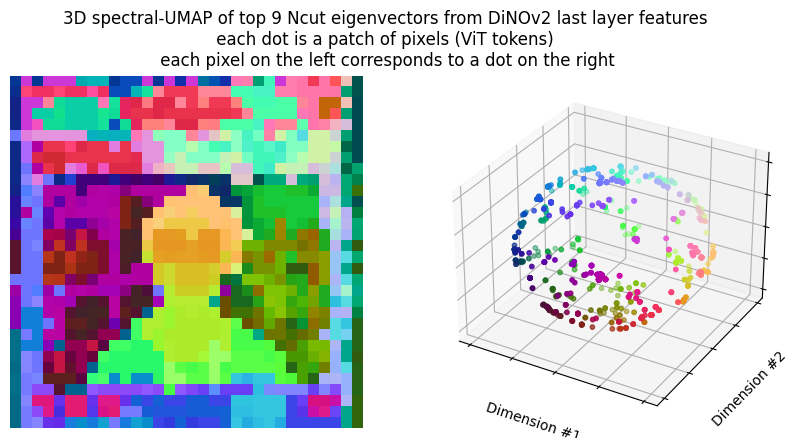

In [ ]:
# %%

# use t-SNE or UMAP to visualize the top 10 eigenvectors in one plot
# from ncut_pytorch import nystrom_tsne, nystrom_umap, quantile_normalize
from ncut_pytorch import rgb_from_umap_sphere

X_3d, rgb = rgb_from_umap_sphere(eigenvectors[:, :10], device="cpu", n_neighbors=100, min_dist=0.1)
plot_3d(X_3d, rgb, "3D spectral-UMAP of top 9 Ncut eigenvectors from DiNOv2 last layer features\n each dot is a patch of pixels (ViT tokens) \n each pixel on the left corresponds to a dot on the right")

<ipython-input-5-b4a42461cfa2>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-5-b4a42461cfa2>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-5-b4a42461cfa2>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(labels)


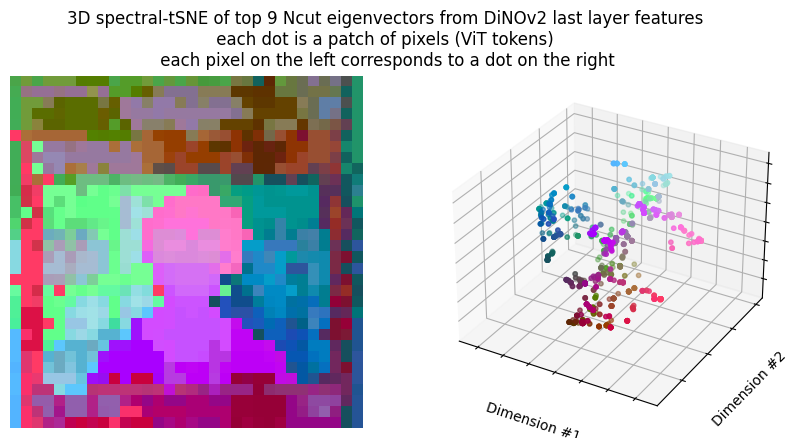

In [ ]:
# %%

from ncut_pytorch import rgb_from_tsne_3d

X_3d, rgb = rgb_from_tsne_3d(eigenvectors[:, :10], device="cpu", perplexity=100)
plot_3d(X_3d, rgb, "3D spectral-tSNE of top 9 Ncut eigenvectors from DiNOv2 last layer features\n each dot is a patch of pixels (ViT tokens) \n each pixel on the left corresponds to a dot on the right")